# **Obteniendo el corpus** 📖

In [1]:
def getData(filename: str) -> str:
    " Lee y almacena en un string todos los carácteres leídos en un archivo .txt "
    rawData = ""
    with open(filename, encoding="utf-8") as f:
        for line in f:
            rawData += line
    return rawData

In [2]:
import os

filepath = os.path.join(os.path.dirname(os.getcwd()), "data", "corpus.txt")
rawCorpus = getData(filepath)
print(f"Carácteres: {len(rawCorpus)}")
print(f"Extracto: \n{rawCorpus[:500]}")

Carácteres: 30562044
Extracto: 
 Buenas tardes.
Sí. Es que son buenos días, pero llegué tarde, porque estábamos tratando temas importantes, desde luego, el tema de la seguridad.
Y hoy nos acompañó la jefa de gobierno de la Ciudad de México, estuvo en la reunión del gabinete de seguridad. Y también se atendió el Programa de Protección a Peregrinos, porque ya estamos en la víspera del día 12 y vienen peregrinos del país, por las carreteras. Y se habló del programa de protección.
Lo mismo del programa de protección, de apoyo, de 


## **Análisis exploratorio** 🔎

El propósito es realizar un análisis exploratorio sobre los datos crudos para tener una base en la toma de desiciones con respecto al pre-procesamiento de datos (limpieza, normalización, etc.).

### Estadísticas simples

- Cantidad de palabras (secuencias de caractéres separados por espacios).
- Cantidad de oraciones (secuencias de palabras separados por un punto).

In [3]:
from nltk.tokenize import word_tokenize, sent_tokenize
words=word_tokenize(rawCorpus, "spanish")
sentences=sent_tokenize(rawCorpus, "spanish")

print("Cantidad de carácteres:", len(rawCorpus))
print("Cantidad de palabras:", len(words))
print("Cantidad de oraciones:", len(sentences))
print("Promedio de carácteres por palabra:", round(len(rawCorpus) / len(words)))
print("Promedio de palabras por oración:", round(len(words) / len(sentences)))

Cantidad de carácteres: 30562044
Cantidad de palabras: 6140945
Cantidad de oraciones: 240895
Promedio de carácteres por palabra: 5
Promedio de palabras por oración: 25


### Distribución del tamaño de las palabras

done


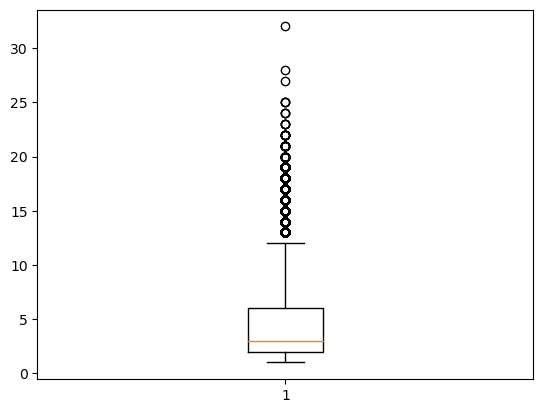

In [4]:
import matplotlib.pyplot as plt

wordSizes = tuple(len(word) for word in words)
plt.boxplot(wordSizes)
print("done")

### Distribución del tamaño de las oraciones

done


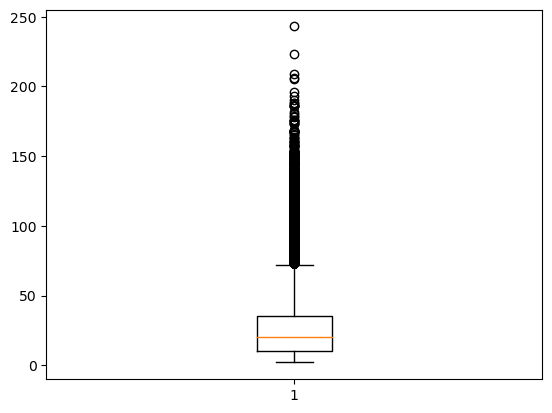

In [10]:
sentenceLength = tuple(len(word_tokenize(sentence, "spanish")) for sentence in sentences)
plt.boxplot(sentenceLength)
print("done")

## **Limpieza de datos** 🧹

In [52]:
import re
def cleanWord(word: str) -> str:
    """ Elimina los signos de punctuación de una palabra """
    return re.sub(r'[^\w]','', word)

def cleanSentence(sentence: str) -> list:
    """ Regresa un listado de las palabras límpias de una oración. """
    words = word_tokenize(sentence)
    cleanWords = [word for word in map(cleanWord, words) if word]
    return cleanWords

In [53]:
cleanSentences = [cleanSentence(sentence) for sentence in sentences]
nCleanWords = sum(len(word) for word in cleanSentences)
print(f"Se limpiaron {len(words) - nCleanWords} palabras.")
print("Promedio de palabras por oración aplicando limpieza:", round( nCleanWords/ len(cleanSentences)))

Se limpiaron 860208 palabras.
Promedio de palabras por oración aplicando limpieza: 22


### Análizando las palabras en el corpus

In [13]:
from collections import defaultdict, Counter
dic=defaultdict(int)

for sentence in cleanSentences:
    for word in sentence:
        dic[word] += 1
        
wordFreq = Counter(dic)
mostFreq = wordFreq.most_common()

### Sin contar las 'stopwords'

In [58]:
import pandas as pd
import plotly.express as px
from nltk.corpus import stopwords
stop=set(stopwords.words('spanish'))
stop.add(".")
stop.add(",")

# Filtering stop words from dic
newDic = dict(filter(lambda pair: pair[0] not in stop, dic.items()))
wordFreq = Counter(newDic)
mostFreq = wordFreq.most_common()

df = pd.DataFrame(mostFreq[:10])
df.columns = ["palabra", "frecuencia"]
fig = px.bar(df, x="palabra", y="frecuencia", color="palabra", title="Frecuencia de palabras sin contar stop-words")
fig.show()

### Wordcloud de palábras

In [ ]:
#%pip install wordcloud

In [66]:
from wordcloud import WordCloud, STOPWORDS

cleanText = " ".join(word for sentence in cleanSentences for word in sentence if word not in stop)

word_cloud = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    background_color="white",
    colormap="jet_r",
    collocations=False,
    max_words=50
    ).generate(cleanText)

In [67]:
fig = px.imshow(word_cloud)
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

## Filtrando palabras con poca ocurrencia

In [68]:
fig = px.violin(dic.values(), box=True, title="Distribución de ocurrencia de palabras")
fig.update_layout(yaxis_title="Veces que aparece")
fig.update_layout(xaxis_title="")
fig.show()

Definiremos a una palabra como poco frecuente si está alejada 4 desviaciones estandar de la media por debajo

In [69]:
N = len(dic)
median = sum(dic.values()) / N
desvStd = sum((value-median)**2 for value in dic.values()) ** 0.5 / N
finalVocab = dict()
counter = 0
for word, freq in dic.items():
    if freq > median - 4 * desvStd:
        finalVocab[word] = freq
    else:
        counter += 1

In [70]:
sizeCorpus = sum(dic.values())
print(f"""Una palabra será <UKN> si aparece menos de {min(finalVocab.values())} veces en el corpus.
Se generaron {counter} OOV de {sizeCorpus} palabras, un {counter/sizeCorpus:.2f}%.""")

Una palabra será <UKN> si aparece menos de 54 veces en el corpus.
Se generaron 47030 OOV de 6068149 palabras, un 0.01%.


### Corpus final

In [71]:
finalCorpus = []
for sentence in cleanSentences:
    finalSentence = [word if word in dic else "<UKN>" for word in sentence]
    finalCorpus.append(finalSentence)

In [72]:
def saveCorpus(corpus: list[list], path: str) -> None:
    """ Guarda un corpus generado al correr esta libreta en un archivo txt definido en path """
    with open(path, mode='a', encoding='utf-8') as f:
        for sentence in corpus:
            f.write(" ".join(word for word in sentence) + '\n')
    print("done.")

def getCorpus(path: str) -> list[list]:
    """ Recupera un corpus guardado en un archivo de txt """
    corpus = []
    with open(path, mode='r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            corpus.append(line.split())
    print("done.")
    return corpus

In [73]:
datasetPath = os.path.join(os.path.dirname(os.getcwd()), "data")
outpath = os.path.join(datasetPath, "cleanCorpus.txt")
saveCorpus(finalCorpus, outpath)

done.


## **Conjunto de entrenamiento y conjunto de prueba**

In [74]:
import random
random.seed(2023)
def splitCorpus(corpus: list[list], splitFactor=0.2) -> tuple:
    """" Separa los datos en un conjunto de entenamiento y uno de prueba, 
         de tal forma que si splitFactor = 0.2 entonces un 20% estará en 
         el conjunto de prueba y el restante el de entrenamiento. """
    splitFactor = max(0.2, splitFactor)
    N = len(corpus)

    randomCorpus = corpus.copy()
    random.shuffle(randomCorpus)
    trainCorpus = randomCorpus[int((N+1)*splitFactor):]
    testCorpus = randomCorpus[:int((N+1)*splitFactor)]

    return trainCorpus, testCorpus

In [76]:
datasetPath = os.path.join(os.path.dirname(os.getcwd()), "data")
data = getCorpus(datasetPath + "/cleanCorpus.txt")
X_train, X_test = splitCorpus(data)
print(f"{len(X_train)} oraciones en el conjunto de entrenamiento.\n{len(X_test)} en el de pruebas.")

done.
192716 oraciones en el conjunto de entrenamiento.
48179 en el de pruebas.
